[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendLine-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-27 00:19:47,041] Making new env: ppaquette/DoomDefendLine-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

1.0 False


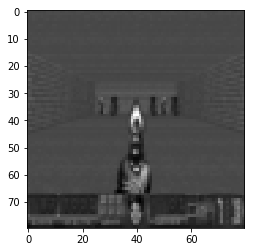

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:
ready_conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='ready_conv0')

ready_conv1 = Conv2DLayer(batch_norm(ready_conv0),64,filter_size=(4,4),stride=(2,2),name='ready_conv1')

ready_dense = DenseLayer(batch_norm(ready_conv1),512,name='ready_dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [9]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [10]:
ready_qvalues_layer = DenseLayer(ready_dense,n_actions,nonlinearity=None,name='ready_qval')


In [11]:
from agentnet.utils.persistence import save,load
load(ready_qvalues_layer, "dist_weights/line_saved_qvalues_layer")

In [12]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(ready_qvalues_layer)
qvalues_right = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [13]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_right),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [14]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [15]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 00:19:48,071] Making new env: ppaquette/DoomDefendLine-v0


In [16]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[3 0 3 0 1 1 0]]
[[ 0.  0.  0.  0.  1.  0.  0.]]
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 86.4 ms


In [17]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [18]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,right_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [19]:
type(right_qvalues_seq)

theano.tensor.var.TensorVariable

In [20]:
from agentnet.learning import qlearning
from lasagne.nonlinearities import softmax
from lasagne.objectives import squared_error
import numpy as np
def my_softmax(x):
    e_x = theano.tensor.exp(x - x.max(axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [21]:


tau = 0.01
softmax_T = my_softmax(right_qvalues_seq / tau)
softmax_S = my_softmax(qvalues_seq / tau)
elwise_loss = softmax_T * np.log(softmax_T / softmax_S)
#elwise_loss = squared_error(right_qvalues_seq, qvalues_seq)

#compute mean over "alive" fragments
loss = elwise_loss.sum() / replay.is_alive.sum()

In [22]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [23]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-27 00:20:18,289] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:20:18,298] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 00:20:18,543] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.17267.video000000.mp4


Episode finished after 57 timesteps with reward=0.0


[2017-06-27 00:20:19,965] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.17267.video000001.mp4


Episode finished after 73 timesteps with reward=3.0
Episode finished after 84 timesteps with reward=3.0
Episode finished after 51 timesteps with reward=1.0
Episode finished after 109 timesteps with reward=6.0
Episode finished after 48 timesteps with reward=2.0
Episode finished after 79 timesteps with reward=5.0


[2017-06-27 00:20:27,262] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.17267.video000008.mp4


Episode finished after 46 timesteps with reward=0.0
Episode finished after 61 timesteps with reward=3.0


[2017-06-27 00:20:29,220] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 40 timesteps with reward=1.0


In [24]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [25]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [26]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:02<07:33,  4.39it/s]

iter=10	epsilon=0.954	reward/step=0.05455


  1%|          | 21/2000 [00:04<07:30,  4.39it/s]

iter=20	epsilon=0.910	reward/step=0.06667


  2%|▏         | 31/2000 [00:07<07:19,  4.48it/s]

iter=30	epsilon=0.868	reward/step=0.06129


  2%|▏         | 40/2000 [00:09<08:14,  3.97it/s]

iter=40	epsilon=0.828	reward/step=0.06829


  2%|▏         | 49/2000 [00:11<07:59,  4.07it/s][2017-06-27 00:20:41,094] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:20:41,102] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.06471
Episode finished after 89 timesteps with reward=6.0
Episode finished after 158 timesteps with reward=15.0
Episode finished after 149 timesteps with reward=16.0
Episode finished after 112 timesteps with reward=9.0


[2017-06-27 00:20:49,914] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:20<1:34:40,  2.91s/it]

Episode finished after 120 timesteps with reward=7.0


  3%|▎         | 60/2000 [00:23<11:15,  2.87it/s]  

iter=60	epsilon=0.754	reward/step=0.05902


  4%|▎         | 70/2000 [00:25<08:31,  3.77it/s]

iter=70	epsilon=0.719	reward/step=0.06338


  4%|▍         | 80/2000 [00:28<08:13,  3.89it/s]

iter=80	epsilon=0.687	reward/step=0.06173


  4%|▍         | 90/2000 [00:30<08:30,  3.74it/s]

iter=90	epsilon=0.656	reward/step=0.06044


  5%|▍         | 99/2000 [00:33<08:06,  3.91it/s][2017-06-27 00:21:02,806] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:21:02,811] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.06436
Episode finished after 90 timesteps with reward=8.0
Episode finished after 138 timesteps with reward=14.0
Episode finished after 70 timesteps with reward=4.0
Episode finished after 177 timesteps with reward=9.0


[2017-06-27 00:21:11,626] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:42<1:32:36,  2.92s/it]

Episode finished after 147 timesteps with reward=17.0


  6%|▌         | 110/2000 [00:44<10:51,  2.90it/s]  

iter=110	epsilon=0.598	reward/step=0.06486


  6%|▌         | 120/2000 [00:47<08:50,  3.54it/s]

iter=120	epsilon=0.571	reward/step=0.06694


  6%|▋         | 130/2000 [00:50<08:42,  3.58it/s]

iter=130	epsilon=0.546	reward/step=0.06718


  7%|▋         | 140/2000 [00:53<08:47,  3.52it/s]

iter=140	epsilon=0.522	reward/step=0.06879


  7%|▋         | 149/2000 [00:55<08:33,  3.61it/s][2017-06-27 00:21:25,057] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:21:25,061] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.06887
Episode finished after 87 timesteps with reward=6.0
Episode finished after 100 timesteps with reward=7.0
Episode finished after 76 timesteps with reward=6.0
Episode finished after 140 timesteps with reward=13.0


[2017-06-27 00:21:32,216] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [01:02<1:15:11,  2.44s/it]

Episode finished after 98 timesteps with reward=10.0


  8%|▊         | 160/2000 [01:05<10:53,  2.82it/s]  

iter=160	epsilon=0.477	reward/step=0.07019


  8%|▊         | 170/2000 [01:08<09:01,  3.38it/s]

iter=170	epsilon=0.456	reward/step=0.07193


  9%|▉         | 180/2000 [01:11<08:53,  3.41it/s]

iter=180	epsilon=0.436	reward/step=0.07182


 10%|▉         | 190/2000 [01:14<08:56,  3.37it/s]

iter=190	epsilon=0.417	reward/step=0.07173


 10%|▉         | 199/2000 [01:16<08:43,  3.44it/s][2017-06-27 00:21:46,502] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:21:46,507] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.07264
Episode finished after 111 timesteps with reward=9.0
Episode finished after 122 timesteps with reward=11.0
Episode finished after 84 timesteps with reward=9.0
Episode finished after 65 timesteps with reward=7.0


[2017-06-27 00:21:54,630] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:25<1:22:28,  2.75s/it]

Episode finished after 181 timesteps with reward=15.0


 10%|█         | 210/2000 [01:28<11:22,  2.62it/s]  

iter=210	epsilon=0.382	reward/step=0.07346


 11%|█         | 220/2000 [01:31<09:53,  3.00it/s]

iter=220	epsilon=0.366	reward/step=0.07466


 12%|█▏        | 230/2000 [01:34<10:01,  2.94it/s]

iter=230	epsilon=0.351	reward/step=0.07489


 12%|█▏        | 240/2000 [01:38<10:05,  2.91it/s]

iter=240	epsilon=0.336	reward/step=0.07552


 12%|█▏        | 249/2000 [01:41<09:54,  2.95it/s][2017-06-27 00:22:10,749] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:22:10,758] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.07689
Episode finished after 82 timesteps with reward=8.0
Episode finished after 128 timesteps with reward=16.0
Episode finished after 97 timesteps with reward=9.0
Episode finished after 65 timesteps with reward=4.0


[2017-06-27 00:22:16,867] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:47<1:03:55,  2.19s/it]

Episode finished after 54 timesteps with reward=4.0


 13%|█▎        | 260/2000 [01:51<12:16,  2.36it/s]  

iter=260	epsilon=0.309	reward/step=0.07893


 14%|█▎        | 270/2000 [01:54<10:26,  2.76it/s]

iter=270	epsilon=0.296	reward/step=0.07934


 14%|█▍        | 280/2000 [01:58<10:25,  2.75it/s]

iter=280	epsilon=0.284	reward/step=0.07865


 14%|█▍        | 290/2000 [02:01<10:22,  2.75it/s]

iter=290	epsilon=0.273	reward/step=0.07835


 15%|█▍        | 299/2000 [02:04<10:14,  2.77it/s][2017-06-27 00:22:34,670] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:22:34,675] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.07833
Episode finished after 62 timesteps with reward=7.0
Episode finished after 116 timesteps with reward=12.0
Episode finished after 121 timesteps with reward=11.0
Episode finished after 172 timesteps with reward=18.0


[2017-06-27 00:22:43,929] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [02:14<1:29:24,  3.16s/it]

Episode finished after 176 timesteps with reward=18.0


 16%|█▌        | 310/2000 [02:18<12:08,  2.32it/s]  

iter=310	epsilon=0.252	reward/step=0.07867


 16%|█▌        | 320/2000 [02:21<10:08,  2.76it/s]

iter=320	epsilon=0.242	reward/step=0.07967


 16%|█▋        | 330/2000 [02:25<09:56,  2.80it/s]

iter=330	epsilon=0.232	reward/step=0.08100


 17%|█▋        | 340/2000 [02:28<09:55,  2.79it/s]

iter=340	epsilon=0.224	reward/step=0.07967


 17%|█▋        | 349/2000 [02:31<09:37,  2.86it/s][2017-06-27 00:23:01,253] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:23:01,258] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.08100
Episode finished after 143 timesteps with reward=15.0
Episode finished after 142 timesteps with reward=13.0
Episode finished after 153 timesteps with reward=15.0
Episode finished after 96 timesteps with reward=8.0


[2017-06-27 00:23:10,253] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:41<1:24:17,  3.07s/it]

Episode finished after 92 timesteps with reward=10.0


 18%|█▊        | 360/2000 [02:44<11:58,  2.28it/s]  

iter=360	epsilon=0.207	reward/step=0.08233


 18%|█▊        | 370/2000 [02:48<09:45,  2.78it/s]

iter=370	epsilon=0.199	reward/step=0.08233


 19%|█▉        | 380/2000 [02:51<09:42,  2.78it/s]

iter=380	epsilon=0.192	reward/step=0.08500


 20%|█▉        | 390/2000 [02:55<09:38,  2.78it/s]

iter=390	epsilon=0.185	reward/step=0.08667


 20%|█▉        | 399/2000 [02:58<09:13,  2.89it/s][2017-06-27 00:23:27,788] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:23:27,794] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.08667
Episode finished after 156 timesteps with reward=14.0
Episode finished after 166 timesteps with reward=15.0
Episode finished after 106 timesteps with reward=12.0
Episode finished after 129 timesteps with reward=16.0


[2017-06-27 00:23:37,743] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [03:08<1:29:16,  3.35s/it]

Episode finished after 138 timesteps with reward=12.0


 20%|██        | 410/2000 [03:11<11:55,  2.22it/s]  

iter=410	epsilon=0.172	reward/step=0.08700


 21%|██        | 420/2000 [03:15<09:29,  2.77it/s]

iter=420	epsilon=0.166	reward/step=0.08733


 22%|██▏       | 430/2000 [03:18<09:20,  2.80it/s]

iter=430	epsilon=0.161	reward/step=0.08833


 22%|██▏       | 440/2000 [03:22<09:22,  2.77it/s]

iter=440	epsilon=0.155	reward/step=0.08800


 22%|██▏       | 449/2000 [03:25<09:03,  2.86it/s][2017-06-27 00:23:55,269] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:23:55,274] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.08867
Episode finished after 129 timesteps with reward=12.0
Episode finished after 320 timesteps with reward=24.0
Episode finished after 159 timesteps with reward=13.0
Episode finished after 179 timesteps with reward=18.0


[2017-06-27 00:24:08,418] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [03:39<1:51:25,  4.31s/it]

Episode finished after 139 timesteps with reward=15.0


 23%|██▎       | 460/2000 [03:42<12:18,  2.09it/s]  

iter=460	epsilon=0.145	reward/step=0.08867


 24%|██▎       | 470/2000 [03:46<09:14,  2.76it/s]

iter=470	epsilon=0.141	reward/step=0.08833


 24%|██▍       | 480/2000 [03:49<09:03,  2.79it/s]

iter=480	epsilon=0.136	reward/step=0.08800


 24%|██▍       | 490/2000 [03:53<09:02,  2.78it/s]

iter=490	epsilon=0.132	reward/step=0.08900


 25%|██▍       | 499/2000 [03:56<08:44,  2.86it/s][2017-06-27 00:24:25,969] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:24:25,974] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.08933
Episode finished after 120 timesteps with reward=15.0
Episode finished after 118 timesteps with reward=13.0
Episode finished after 70 timesteps with reward=9.0
Episode finished after 167 timesteps with reward=13.0


[2017-06-27 00:24:34,633] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [04:05<1:14:04,  2.96s/it]

Episode finished after 129 timesteps with reward=14.0


 26%|██▌       | 510/2000 [04:08<10:44,  2.31it/s]  

iter=510	epsilon=0.124	reward/step=0.09000


 26%|██▌       | 520/2000 [04:12<08:54,  2.77it/s]

iter=520	epsilon=0.121	reward/step=0.09000


 26%|██▋       | 530/2000 [04:15<08:51,  2.76it/s]

iter=530	epsilon=0.117	reward/step=0.09133


 27%|██▋       | 540/2000 [04:19<08:47,  2.77it/s]

iter=540	epsilon=0.114	reward/step=0.09133


 27%|██▋       | 549/2000 [04:22<08:30,  2.84it/s][2017-06-27 00:24:52,074] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:24:52,079] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.09067
Episode finished after 141 timesteps with reward=18.0
Episode finished after 175 timesteps with reward=19.0
Episode finished after 92 timesteps with reward=11.0
Episode finished after 83 timesteps with reward=9.0


[2017-06-27 00:25:00,761] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [04:31<1:11:58,  2.98s/it]

Episode finished after 112 timesteps with reward=13.0


 28%|██▊       | 560/2000 [04:34<10:22,  2.31it/s]  

iter=560	epsilon=0.108	reward/step=0.08967


 28%|██▊       | 570/2000 [04:38<08:34,  2.78it/s]

iter=570	epsilon=0.105	reward/step=0.09033


 29%|██▉       | 580/2000 [04:41<08:29,  2.79it/s]

iter=580	epsilon=0.102	reward/step=0.09100


 30%|██▉       | 590/2000 [04:45<08:26,  2.78it/s]

iter=590	epsilon=0.100	reward/step=0.09200


 30%|██▉       | 599/2000 [04:48<08:06,  2.88it/s][2017-06-27 00:25:18,151] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:25:18,155] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.09300
Episode finished after 105 timesteps with reward=12.0
Episode finished after 83 timesteps with reward=7.0
Episode finished after 87 timesteps with reward=12.0
Episode finished after 165 timesteps with reward=17.0


[2017-06-27 00:25:26,759] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [04:57<1:08:43,  2.95s/it]

Episode finished after 158 timesteps with reward=15.0


 30%|███       | 610/2000 [05:00<10:05,  2.29it/s]  

iter=610	epsilon=0.095	reward/step=0.09333


 31%|███       | 620/2000 [05:04<08:18,  2.77it/s]

iter=620	epsilon=0.093	reward/step=0.09233


 32%|███▏      | 630/2000 [05:07<08:06,  2.82it/s]

iter=630	epsilon=0.091	reward/step=0.09000


 32%|███▏      | 640/2000 [05:11<08:12,  2.76it/s]

iter=640	epsilon=0.089	reward/step=0.09167


 32%|███▏      | 649/2000 [05:14<07:54,  2.84it/s][2017-06-27 00:25:44,260] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:25:44,265] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.09267
Episode finished after 116 timesteps with reward=16.0
Episode finished after 119 timesteps with reward=12.0
Episode finished after 226 timesteps with reward=16.0
Episode finished after 85 timesteps with reward=11.0


[2017-06-27 00:25:53,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [05:24<1:10:50,  3.15s/it]

Episode finished after 101 timesteps with reward=9.0


 33%|███▎      | 660/2000 [05:27<10:03,  2.22it/s]  

iter=660	epsilon=0.085	reward/step=0.09367


 34%|███▎      | 670/2000 [05:31<07:59,  2.77it/s]

iter=670	epsilon=0.083	reward/step=0.09367


 34%|███▍      | 680/2000 [05:34<07:52,  2.79it/s]

iter=680	epsilon=0.082	reward/step=0.09333


 34%|███▍      | 690/2000 [05:38<07:52,  2.77it/s]

iter=690	epsilon=0.080	reward/step=0.09300


 35%|███▍      | 699/2000 [05:41<07:34,  2.86it/s][2017-06-27 00:26:11,181] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:26:11,186] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.09333
Episode finished after 96 timesteps with reward=11.0
Episode finished after 155 timesteps with reward=19.0
Episode finished after 193 timesteps with reward=21.0
Episode finished after 89 timesteps with reward=9.0


[2017-06-27 00:26:20,775] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [05:51<1:10:19,  3.25s/it]

Episode finished after 137 timesteps with reward=13.0


 36%|███▌      | 710/2000 [05:54<09:29,  2.27it/s]  

iter=710	epsilon=0.077	reward/step=0.09400


 36%|███▌      | 720/2000 [05:58<07:50,  2.72it/s]

iter=720	epsilon=0.076	reward/step=0.09433


 36%|███▋      | 730/2000 [06:02<07:39,  2.77it/s]

iter=730	epsilon=0.075	reward/step=0.09433


 37%|███▋      | 740/2000 [06:05<07:34,  2.77it/s]

iter=740	epsilon=0.073	reward/step=0.09433


 37%|███▋      | 749/2000 [06:08<07:12,  2.89it/s][2017-06-27 00:26:38,268] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:26:38,273] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.09367
Episode finished after 143 timesteps with reward=15.0
Episode finished after 127 timesteps with reward=10.0
Episode finished after 208 timesteps with reward=22.0
Episode finished after 151 timesteps with reward=15.0


[2017-06-27 00:26:49,429] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [06:20<1:17:21,  3.71s/it]

Episode finished after 151 timesteps with reward=19.0


 38%|███▊      | 760/2000 [06:23<09:42,  2.13it/s]  

iter=760	epsilon=0.071	reward/step=0.09467


 38%|███▊      | 770/2000 [06:27<07:42,  2.66it/s]

iter=770	epsilon=0.070	reward/step=0.09400


 39%|███▉      | 780/2000 [06:30<07:23,  2.75it/s]

iter=780	epsilon=0.069	reward/step=0.09567


 40%|███▉      | 790/2000 [06:34<07:14,  2.78it/s]

iter=790	epsilon=0.068	reward/step=0.09600


 40%|███▉      | 799/2000 [06:37<07:01,  2.85it/s][2017-06-27 00:27:07,263] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:27:07,267] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.09567
Episode finished after 114 timesteps with reward=13.0
Episode finished after 124 timesteps with reward=16.0
Episode finished after 90 timesteps with reward=8.0
Episode finished after 118 timesteps with reward=15.0


[2017-06-27 00:27:15,322] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [06:46<55:42,  2.79s/it]

Episode finished after 110 timesteps with reward=13.0


 40%|████      | 810/2000 [06:49<08:35,  2.31it/s]

iter=810	epsilon=0.067	reward/step=0.09600


 41%|████      | 820/2000 [06:53<07:14,  2.72it/s]

iter=820	epsilon=0.066	reward/step=0.09633


 42%|████▏     | 830/2000 [06:56<07:04,  2.76it/s]

iter=830	epsilon=0.065	reward/step=0.09600


 42%|████▏     | 840/2000 [07:00<07:00,  2.76it/s]

iter=840	epsilon=0.064	reward/step=0.09667


 42%|████▏     | 849/2000 [07:03<06:37,  2.89it/s][2017-06-27 00:27:32,867] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:27:32,872] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.09700
Episode finished after 74 timesteps with reward=6.0
Episode finished after 138 timesteps with reward=14.0
Episode finished after 103 timesteps with reward=11.0
Episode finished after 116 timesteps with reward=13.0


[2017-06-27 00:27:40,892] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [07:11<53:08,  2.77s/it]

Episode finished after 117 timesteps with reward=15.0


 43%|████▎     | 860/2000 [07:15<08:21,  2.27it/s]

iter=860	epsilon=0.063	reward/step=0.09733


 44%|████▎     | 870/2000 [07:18<06:48,  2.77it/s]

iter=870	epsilon=0.062	reward/step=0.09667


 44%|████▍     | 880/2000 [07:22<06:42,  2.78it/s]

iter=880	epsilon=0.062	reward/step=0.09767


 44%|████▍     | 890/2000 [07:25<06:40,  2.77it/s]

iter=890	epsilon=0.061	reward/step=0.09733


 45%|████▍     | 899/2000 [07:28<06:23,  2.87it/s][2017-06-27 00:27:58,553] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:27:58,558] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.09700
Episode finished after 112 timesteps with reward=12.0
Episode finished after 119 timesteps with reward=12.0
Episode finished after 112 timesteps with reward=14.0
Episode finished after 59 timesteps with reward=6.0


[2017-06-27 00:28:06,753] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [07:37<51:47,  2.82s/it]

Episode finished after 164 timesteps with reward=23.0


 46%|████▌     | 910/2000 [07:40<07:47,  2.33it/s]

iter=910	epsilon=0.060	reward/step=0.09800


 46%|████▌     | 920/2000 [07:44<06:27,  2.79it/s]

iter=920	epsilon=0.060	reward/step=0.09867


 46%|████▋     | 930/2000 [07:47<06:24,  2.79it/s]

iter=930	epsilon=0.059	reward/step=0.10133


 47%|████▋     | 940/2000 [07:51<06:19,  2.80it/s]

iter=940	epsilon=0.059	reward/step=0.10100


 47%|████▋     | 949/2000 [07:54<06:06,  2.87it/s][2017-06-27 00:28:24,166] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:28:24,171] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.09933
Episode finished after 89 timesteps with reward=11.0
Episode finished after 98 timesteps with reward=12.0
Episode finished after 124 timesteps with reward=15.0
Episode finished after 102 timesteps with reward=11.0


[2017-06-27 00:28:31,696] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [08:02<45:54,  2.62s/it]

Episode finished after 105 timesteps with reward=13.0


 48%|████▊     | 960/2000 [08:06<07:31,  2.30it/s]

iter=960	epsilon=0.058	reward/step=0.09867


 48%|████▊     | 970/2000 [08:09<06:14,  2.75it/s]

iter=970	epsilon=0.057	reward/step=0.09833


 49%|████▉     | 980/2000 [08:13<06:07,  2.78it/s]

iter=980	epsilon=0.057	reward/step=0.09733


 50%|████▉     | 990/2000 [08:16<06:02,  2.78it/s]

iter=990	epsilon=0.057	reward/step=0.09700


 50%|████▉     | 999/2000 [08:19<05:44,  2.91it/s][2017-06-27 00:28:49,344] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:28:49,348] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.09700
Episode finished after 185 timesteps with reward=23.0
Episode finished after 145 timesteps with reward=17.0
Episode finished after 117 timesteps with reward=11.0
Episode finished after 97 timesteps with reward=10.0


[2017-06-27 00:28:58,826] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [08:29<53:28,  3.21s/it]

Episode finished after 113 timesteps with reward=12.0


 50%|█████     | 1010/2000 [08:33<07:15,  2.27it/s]

iter=1010	epsilon=0.056	reward/step=0.09633


 51%|█████     | 1020/2000 [08:36<05:56,  2.75it/s]

iter=1020	epsilon=0.056	reward/step=0.09600


 52%|█████▏    | 1030/2000 [08:40<05:48,  2.79it/s]

iter=1030	epsilon=0.056	reward/step=0.09633


 52%|█████▏    | 1040/2000 [08:43<05:44,  2.79it/s]

iter=1040	epsilon=0.055	reward/step=0.09667


 52%|█████▏    | 1049/2000 [08:46<05:30,  2.88it/s][2017-06-27 00:29:16,280] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:29:16,285] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.09733
Episode finished after 201 timesteps with reward=22.0
Episode finished after 141 timesteps with reward=13.0
Episode finished after 126 timesteps with reward=14.0
Episode finished after 109 timesteps with reward=13.0


[2017-06-27 00:29:25,504] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [08:56<49:35,  3.13s/it]

Episode finished after 64 timesteps with reward=6.0


 53%|█████▎    | 1060/2000 [08:59<06:55,  2.26it/s]

iter=1060	epsilon=0.055	reward/step=0.09633


 54%|█████▎    | 1070/2000 [09:03<05:40,  2.73it/s]

iter=1070	epsilon=0.055	reward/step=0.09767


 54%|█████▍    | 1080/2000 [09:06<05:32,  2.77it/s]

iter=1080	epsilon=0.054	reward/step=0.09667


 55%|█████▍    | 1090/2000 [09:10<05:26,  2.79it/s]

iter=1090	epsilon=0.054	reward/step=0.09633


 55%|█████▍    | 1099/2000 [09:13<05:18,  2.83it/s][2017-06-27 00:29:43,079] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:29:43,084] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.09667
Episode finished after 174 timesteps with reward=22.0
Episode finished after 116 timesteps with reward=9.0
Episode finished after 107 timesteps with reward=12.0
Episode finished after 99 timesteps with reward=12.0


[2017-06-27 00:29:51,746] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [09:22<44:32,  2.97s/it]

Episode finished after 103 timesteps with reward=12.0


 56%|█████▌    | 1110/2000 [09:26<06:31,  2.27it/s]

iter=1110	epsilon=0.054	reward/step=0.09533


 56%|█████▌    | 1120/2000 [09:29<05:22,  2.73it/s]

iter=1120	epsilon=0.054	reward/step=0.09467


 56%|█████▋    | 1130/2000 [09:33<05:15,  2.76it/s]

iter=1130	epsilon=0.053	reward/step=0.09333


 57%|█████▋    | 1140/2000 [09:36<05:13,  2.74it/s]

iter=1140	epsilon=0.053	reward/step=0.09200


 57%|█████▋    | 1149/2000 [09:39<04:56,  2.87it/s][2017-06-27 00:30:09,342] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:30:09,346] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.09267
Episode finished after 66 timesteps with reward=8.0
Episode finished after 167 timesteps with reward=19.0
Episode finished after 157 timesteps with reward=12.0
Episode finished after 129 timesteps with reward=15.0


[2017-06-27 00:30:19,000] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [09:49<46:17,  3.27s/it]

Episode finished after 150 timesteps with reward=15.0


 58%|█████▊    | 1160/2000 [09:53<06:27,  2.17it/s]

iter=1160	epsilon=0.053	reward/step=0.09233


 58%|█████▊    | 1170/2000 [09:56<05:02,  2.75it/s]

iter=1170	epsilon=0.053	reward/step=0.09200


 59%|█████▉    | 1180/2000 [10:00<04:56,  2.77it/s]

iter=1180	epsilon=0.053	reward/step=0.09133


 60%|█████▉    | 1190/2000 [10:03<04:49,  2.80it/s]

iter=1190	epsilon=0.052	reward/step=0.09133


 60%|█████▉    | 1199/2000 [10:07<04:39,  2.87it/s][2017-06-27 00:30:36,733] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:30:36,737] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.09033
Episode finished after 97 timesteps with reward=13.0
Episode finished after 107 timesteps with reward=11.0
Episode finished after 187 timesteps with reward=20.0
Episode finished after 94 timesteps with reward=9.0


[2017-06-27 00:30:46,479] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [10:17<43:49,  3.29s/it]

Episode finished after 190 timesteps with reward=23.0


 60%|██████    | 1210/2000 [10:20<05:48,  2.27it/s]

iter=1210	epsilon=0.052	reward/step=0.08833


 61%|██████    | 1220/2000 [10:24<04:39,  2.79it/s]

iter=1220	epsilon=0.052	reward/step=0.08767


 62%|██████▏   | 1230/2000 [10:27<04:37,  2.78it/s]

iter=1230	epsilon=0.052	reward/step=0.08767


 62%|██████▏   | 1240/2000 [10:31<04:31,  2.80it/s]

iter=1240	epsilon=0.052	reward/step=0.08700


 62%|██████▏   | 1249/2000 [10:34<04:20,  2.88it/s][2017-06-27 00:31:03,858] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:31:03,863] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.08833
Episode finished after 94 timesteps with reward=9.0
Episode finished after 53 timesteps with reward=5.0
Episode finished after 120 timesteps with reward=11.0
Episode finished after 157 timesteps with reward=16.0


[2017-06-27 00:31:12,826] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [10:43<38:11,  3.06s/it]

Episode finished after 200 timesteps with reward=21.0


 63%|██████▎   | 1260/2000 [10:47<05:21,  2.30it/s]

iter=1260	epsilon=0.052	reward/step=0.08900


 64%|██████▎   | 1270/2000 [10:50<04:26,  2.74it/s]

iter=1270	epsilon=0.052	reward/step=0.09033


 64%|██████▍   | 1280/2000 [10:54<04:18,  2.78it/s]

iter=1280	epsilon=0.052	reward/step=0.09000


 64%|██████▍   | 1290/2000 [10:57<04:17,  2.75it/s]

iter=1290	epsilon=0.052	reward/step=0.09100


 65%|██████▍   | 1299/2000 [11:00<04:04,  2.86it/s][2017-06-27 00:31:30,358] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:31:30,362] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.09067
Episode finished after 105 timesteps with reward=10.0
Episode finished after 126 timesteps with reward=13.0
Episode finished after 88 timesteps with reward=10.0
Episode finished after 131 timesteps with reward=13.0


[2017-06-27 00:31:38,623] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [11:09<33:16,  2.85s/it]

Episode finished after 124 timesteps with reward=11.0


 66%|██████▌   | 1310/2000 [11:12<04:58,  2.31it/s]

iter=1310	epsilon=0.051	reward/step=0.09167


 66%|██████▌   | 1320/2000 [11:16<04:07,  2.75it/s]

iter=1320	epsilon=0.051	reward/step=0.09200


 66%|██████▋   | 1330/2000 [11:19<04:02,  2.76it/s]

iter=1330	epsilon=0.051	reward/step=0.09133


 67%|██████▋   | 1340/2000 [11:23<03:55,  2.80it/s]

iter=1340	epsilon=0.051	reward/step=0.09167


 67%|██████▋   | 1349/2000 [11:26<03:46,  2.88it/s][2017-06-27 00:31:56,127] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:31:56,132] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.09167
Episode finished after 95 timesteps with reward=11.0
Episode finished after 217 timesteps with reward=25.0
Episode finished after 135 timesteps with reward=16.0
Episode finished after 59 timesteps with reward=6.0


[2017-06-27 00:32:04,860] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [11:35<32:17,  2.98s/it]

Episode finished after 99 timesteps with reward=10.0


 68%|██████▊   | 1360/2000 [11:39<04:37,  2.31it/s]

iter=1360	epsilon=0.051	reward/step=0.09133


 68%|██████▊   | 1370/2000 [11:42<03:48,  2.76it/s]

iter=1370	epsilon=0.051	reward/step=0.09033


 69%|██████▉   | 1380/2000 [11:46<03:43,  2.77it/s]

iter=1380	epsilon=0.051	reward/step=0.09167


 70%|██████▉   | 1390/2000 [11:49<03:39,  2.78it/s]

iter=1390	epsilon=0.051	reward/step=0.09033


 70%|██████▉   | 1399/2000 [11:52<03:29,  2.87it/s][2017-06-27 00:32:22,282] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:32:22,287] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.09033
Episode finished after 141 timesteps with reward=14.0
Episode finished after 111 timesteps with reward=10.0
Episode finished after 143 timesteps with reward=17.0
Episode finished after 136 timesteps with reward=18.0


[2017-06-27 00:32:31,456] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [12:02<31:10,  3.12s/it]

Episode finished after 105 timesteps with reward=12.0


 70%|███████   | 1410/2000 [12:05<04:17,  2.29it/s]

iter=1410	epsilon=0.051	reward/step=0.09033


 71%|███████   | 1420/2000 [12:09<03:30,  2.76it/s]

iter=1420	epsilon=0.051	reward/step=0.09033


 72%|███████▏  | 1430/2000 [12:12<03:25,  2.77it/s]

iter=1430	epsilon=0.051	reward/step=0.09167


 72%|███████▏  | 1440/2000 [12:16<03:21,  2.78it/s]

iter=1440	epsilon=0.051	reward/step=0.09233


 72%|███████▏  | 1449/2000 [12:19<03:11,  2.88it/s][2017-06-27 00:32:48,860] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:32:48,865] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.09100
Episode finished after 113 timesteps with reward=12.0
Episode finished after 74 timesteps with reward=7.0
Episode finished after 212 timesteps with reward=21.0
Episode finished after 89 timesteps with reward=8.0


[2017-06-27 00:32:57,799] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [12:28<27:57,  3.05s/it]

Episode finished after 121 timesteps with reward=13.0


 73%|███████▎  | 1460/2000 [12:32<03:52,  2.32it/s]

iter=1460	epsilon=0.051	reward/step=0.09033


 74%|███████▎  | 1470/2000 [12:35<03:10,  2.78it/s]

iter=1470	epsilon=0.051	reward/step=0.09167


 74%|███████▍  | 1480/2000 [12:38<03:05,  2.81it/s]

iter=1480	epsilon=0.051	reward/step=0.09200


 74%|███████▍  | 1490/2000 [12:42<03:03,  2.78it/s]

iter=1490	epsilon=0.051	reward/step=0.09267


 75%|███████▍  | 1499/2000 [12:45<02:54,  2.87it/s][2017-06-27 00:33:15,175] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:33:15,180] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.09400
Episode finished after 160 timesteps with reward=19.0
Episode finished after 96 timesteps with reward=11.0
Episode finished after 128 timesteps with reward=13.0
Episode finished after 61 timesteps with reward=6.0


[2017-06-27 00:33:22,502] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [12:53<21:19,  2.56s/it]

Episode finished after 62 timesteps with reward=6.0


 76%|███████▌  | 1510/2000 [12:56<03:25,  2.38it/s]

iter=1510	epsilon=0.050	reward/step=0.09467


 76%|███████▌  | 1520/2000 [13:00<02:52,  2.78it/s]

iter=1520	epsilon=0.050	reward/step=0.09500


 76%|███████▋  | 1530/2000 [13:03<02:49,  2.77it/s]

iter=1530	epsilon=0.050	reward/step=0.09467


 77%|███████▋  | 1540/2000 [13:07<02:45,  2.78it/s]

iter=1540	epsilon=0.050	reward/step=0.09633


 77%|███████▋  | 1549/2000 [13:10<02:35,  2.90it/s][2017-06-27 00:33:39,920] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:33:39,925] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.09567
Episode finished after 159 timesteps with reward=17.0
Episode finished after 102 timesteps with reward=12.0
Episode finished after 186 timesteps with reward=15.0
Episode finished after 131 timesteps with reward=10.0


[2017-06-27 00:33:51,657] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [13:22<29:09,  3.89s/it]

Episode finished after 247 timesteps with reward=25.0


 78%|███████▊  | 1560/2000 [13:26<03:26,  2.13it/s]

iter=1560	epsilon=0.050	reward/step=0.09533


 78%|███████▊  | 1570/2000 [13:29<02:36,  2.74it/s]

iter=1570	epsilon=0.050	reward/step=0.09467


 79%|███████▉  | 1580/2000 [13:33<02:32,  2.75it/s]

iter=1580	epsilon=0.050	reward/step=0.09467


 80%|███████▉  | 1590/2000 [13:36<02:26,  2.80it/s]

iter=1590	epsilon=0.050	reward/step=0.09500


 80%|███████▉  | 1599/2000 [13:39<02:19,  2.87it/s][2017-06-27 00:34:09,333] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:34:09,338] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.09367
Episode finished after 100 timesteps with reward=11.0
Episode finished after 111 timesteps with reward=14.0
Episode finished after 107 timesteps with reward=8.0
Episode finished after 97 timesteps with reward=12.0


[2017-06-27 00:34:16,685] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [13:47<17:05,  2.56s/it]

Episode finished after 97 timesteps with reward=10.0


 80%|████████  | 1610/2000 [13:50<02:43,  2.39it/s]

iter=1610	epsilon=0.050	reward/step=0.09300


 81%|████████  | 1620/2000 [13:54<02:16,  2.79it/s]

iter=1620	epsilon=0.050	reward/step=0.09233


 82%|████████▏ | 1630/2000 [13:57<02:14,  2.75it/s]

iter=1630	epsilon=0.050	reward/step=0.09267


 82%|████████▏ | 1640/2000 [14:01<02:09,  2.78it/s]

iter=1640	epsilon=0.050	reward/step=0.09233


 82%|████████▏ | 1649/2000 [14:04<02:03,  2.85it/s][2017-06-27 00:34:34,132] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:34:34,137] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.09333
Episode finished after 170 timesteps with reward=20.0
Episode finished after 121 timesteps with reward=14.0
Episode finished after 72 timesteps with reward=6.0
Episode finished after 143 timesteps with reward=14.0


[2017-06-27 00:34:42,965] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [14:13<17:36,  3.02s/it]

Episode finished after 99 timesteps with reward=10.0


 83%|████████▎ | 1660/2000 [14:17<02:31,  2.24it/s]

iter=1660	epsilon=0.050	reward/step=0.09333


 84%|████████▎ | 1670/2000 [14:20<01:58,  2.78it/s]

iter=1670	epsilon=0.050	reward/step=0.09300


 84%|████████▍ | 1680/2000 [14:24<01:54,  2.79it/s]

iter=1680	epsilon=0.050	reward/step=0.09167


 84%|████████▍ | 1690/2000 [14:27<01:53,  2.74it/s]

iter=1690	epsilon=0.050	reward/step=0.09300


 85%|████████▍ | 1699/2000 [14:30<01:44,  2.88it/s][2017-06-27 00:35:00,658] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:35:00,662] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.09300
Episode finished after 104 timesteps with reward=13.0
Episode finished after 119 timesteps with reward=11.0
Episode finished after 140 timesteps with reward=12.0
Episode finished after 106 timesteps with reward=16.0


[2017-06-27 00:35:09,655] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [14:40<15:18,  3.06s/it]

Episode finished after 159 timesteps with reward=16.0


 86%|████████▌ | 1710/2000 [14:43<02:07,  2.28it/s]

iter=1710	epsilon=0.050	reward/step=0.09300


 86%|████████▌ | 1720/2000 [14:47<01:41,  2.76it/s]

iter=1720	epsilon=0.050	reward/step=0.09300


 86%|████████▋ | 1730/2000 [14:50<01:37,  2.76it/s]

iter=1730	epsilon=0.050	reward/step=0.09200


 87%|████████▋ | 1740/2000 [14:54<01:35,  2.73it/s]

iter=1740	epsilon=0.050	reward/step=0.09167


 87%|████████▋ | 1749/2000 [14:57<01:28,  2.84it/s][2017-06-27 00:35:27,223] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:35:27,227] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.09300
Episode finished after 146 timesteps with reward=14.0
Episode finished after 143 timesteps with reward=14.0
Episode finished after 79 timesteps with reward=8.0
Episode finished after 119 timesteps with reward=15.0


[2017-06-27 00:35:35,949] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [15:06<12:27,  2.99s/it]

Episode finished after 114 timesteps with reward=13.0


 88%|████████▊ | 1760/2000 [15:10<01:44,  2.29it/s]

iter=1760	epsilon=0.050	reward/step=0.09300


 88%|████████▊ | 1770/2000 [15:13<01:23,  2.76it/s]

iter=1770	epsilon=0.050	reward/step=0.09233


 89%|████████▉ | 1780/2000 [15:17<01:19,  2.77it/s]

iter=1780	epsilon=0.050	reward/step=0.09233


 90%|████████▉ | 1790/2000 [15:20<01:16,  2.74it/s]

iter=1790	epsilon=0.050	reward/step=0.09100


 90%|████████▉ | 1799/2000 [15:23<01:10,  2.85it/s][2017-06-27 00:35:53,604] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:35:53,609] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.09067
Episode finished after 156 timesteps with reward=15.0
Episode finished after 114 timesteps with reward=11.0
Episode finished after 128 timesteps with reward=14.0
Episode finished after 92 timesteps with reward=12.0


[2017-06-27 00:36:01,712] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [15:32<09:19,  2.80s/it]

Episode finished after 74 timesteps with reward=6.0


 90%|█████████ | 1810/2000 [15:35<01:21,  2.34it/s]

iter=1810	epsilon=0.050	reward/step=0.09167


 91%|█████████ | 1820/2000 [15:39<01:04,  2.78it/s]

iter=1820	epsilon=0.050	reward/step=0.09067


 92%|█████████▏| 1830/2000 [15:42<01:01,  2.76it/s]

iter=1830	epsilon=0.050	reward/step=0.09067


 92%|█████████▏| 1840/2000 [15:46<00:57,  2.79it/s]

iter=1840	epsilon=0.050	reward/step=0.08967


 92%|█████████▏| 1849/2000 [15:49<00:52,  2.89it/s][2017-06-27 00:36:19,144] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:36:19,149] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.09033
Episode finished after 136 timesteps with reward=13.0
Episode finished after 132 timesteps with reward=15.0
Episode finished after 168 timesteps with reward=21.0
Episode finished after 120 timesteps with reward=11.0


[2017-06-27 00:36:29,392] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [16:00<08:35,  3.44s/it]

Episode finished after 135 timesteps with reward=15.0


 93%|█████████▎| 1860/2000 [16:03<01:03,  2.20it/s]

iter=1860	epsilon=0.050	reward/step=0.09033


 94%|█████████▎| 1870/2000 [16:07<00:46,  2.78it/s]

iter=1870	epsilon=0.050	reward/step=0.08900


 94%|█████████▍| 1880/2000 [16:10<00:43,  2.76it/s]

iter=1880	epsilon=0.050	reward/step=0.08967


 94%|█████████▍| 1890/2000 [16:14<00:39,  2.78it/s]

iter=1890	epsilon=0.050	reward/step=0.08900


 95%|█████████▍| 1899/2000 [16:17<00:35,  2.84it/s][2017-06-27 00:36:47,100] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:36:47,105] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.09033
Episode finished after 147 timesteps with reward=15.0
Episode finished after 89 timesteps with reward=9.0
Episode finished after 64 timesteps with reward=7.0
Episode finished after 163 timesteps with reward=19.0


[2017-06-27 00:36:55,918] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [16:26<05:01,  3.02s/it]

Episode finished after 147 timesteps with reward=16.0


 96%|█████████▌| 1910/2000 [16:30<00:39,  2.29it/s]

iter=1910	epsilon=0.050	reward/step=0.09100


 96%|█████████▌| 1920/2000 [16:33<00:28,  2.77it/s]

iter=1920	epsilon=0.050	reward/step=0.09133


 96%|█████████▋| 1930/2000 [16:37<00:25,  2.75it/s]

iter=1930	epsilon=0.050	reward/step=0.09133


 97%|█████████▋| 1940/2000 [16:40<00:21,  2.76it/s]

iter=1940	epsilon=0.050	reward/step=0.09167


 97%|█████████▋| 1949/2000 [16:43<00:18,  2.81it/s][2017-06-27 00:37:13,528] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-27 00:37:13,533] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.09133
Episode finished after 150 timesteps with reward=12.0
Episode finished after 66 timesteps with reward=8.0
Episode finished after 85 timesteps with reward=8.0
Episode finished after 103 timesteps with reward=14.0


[2017-06-27 00:37:21,367] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [16:52<02:16,  2.72s/it]

Episode finished after 132 timesteps with reward=16.0


 98%|█████████▊| 1960/2000 [16:55<00:17,  2.27it/s]

iter=1960	epsilon=0.050	reward/step=0.09167


 98%|█████████▊| 1970/2000 [16:59<00:10,  2.76it/s]

iter=1970	epsilon=0.050	reward/step=0.09300


 99%|█████████▊| 1971/2000 [16:59<00:09,  2.90it/s]

KeyboardInterrupt: 

# Evaluating results
 * Here we plot learning curves and sample testimonials

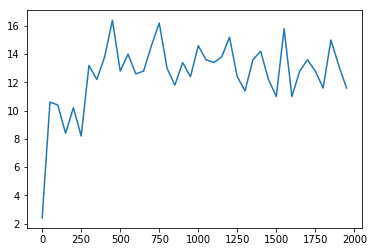

In [27]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [28]:
import os
tmp = GAME_NAME.split('/')[1]
#os.mkdir(tmp)
with open('{}/distilled_single'.format(tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

In [ ]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
#gym.upload('/home/ubuntu/records')

In [29]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/distilled_single.pcl".format(tmp))

In [ ]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets